<a href="https://colab.research.google.com/github/lucioew28/TCC/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Imports e Setup Inicial

In [19]:
#imports
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [20]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
file_path = '/content/drive/My Drive/TCC/properties_list.csv'

df = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1',)
df.head()

,Cidade,Bairro,Preço,Valor de avaliação,Desconto,Descrição,Modalidade de venda
0,ARACRUZ,GUAXINDIBA,"160.000,54","145.000,00",0.0,"Casa, 0.00 de área total, 96.00 de área privat...",Leilão SFI - Edital Único
1,BAIXO GUANDU,CENTRO,"150.000,00","115.000,00",0.0,"Casa, 0.00 de área total, 61.57 de área privat...",Leilão SFI - Edital Único
2,CACHOEIRO DE ITAPEMIRIM,SAO FRANCISCO DE ASSIS,"84.000,00","140.000,00",40.0,"Apartamento, 0.00 de área total, 49.49 de área...",Licitação Aberta
3,CACHOEIRO DE ITAPEMIRIM,SAO LUCAS,"79.800,00","133.000,00",40.0,"Apartamento, 0.00 de área total, 45.30 de área...",Licitação Aberta
4,CACHOEIRO DE ITAPEMIRIM,SAO FRANCISCO DE ASSIS,"152.460,00","152.460,00",0.0,"Apartamento, 0.00 de área total, 49.49 de área...",Leilão SFI - Edital Único


# 2 Coleta e Preparação dos Dados


## 2.1 Limpeza dos Dados

In [22]:
# Removendo as colunas indesejadas
# df = df.drop(columns=["Preço", "Desconto", "Bairro"])

# Convertendo colunas "Preço" e "Valor de avaliação" para valores numéricos
df['Preço'] = df['Preço'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
df['Valor de avaliação'] = df['Valor de avaliação'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)

# Convertendo strings para números
df['Preço'] = pd.to_numeric(df['Preço'], errors='coerce')
df['Valor de avaliação'] = pd.to_numeric(df['Valor de avaliação'], errors='coerce')

df.head()

,Cidade,Bairro,Preço,Valor de avaliação,Desconto,Descrição,Modalidade de venda
0,ARACRUZ,GUAXINDIBA,160000.54,145000.0,0.0,"Casa, 0.00 de área total, 96.00 de área privat...",Leilão SFI - Edital Único
1,BAIXO GUANDU,CENTRO,150000.00,115000.0,0.0,"Casa, 0.00 de área total, 61.57 de área privat...",Leilão SFI - Edital Único
2,CACHOEIRO DE ITAPEMIRIM,SAO FRANCISCO DE ASSIS,84000.00,140000.0,40.0,"Apartamento, 0.00 de área total, 49.49 de área...",Licitação Aberta
3,CACHOEIRO DE ITAPEMIRIM,SAO LUCAS,79800.00,133000.0,40.0,"Apartamento, 0.00 de área total, 45.30 de área...",Licitação Aberta
4,CACHOEIRO DE ITAPEMIRIM,SAO FRANCISCO DE ASSIS,152460.00,152460.0,0.0,"Apartamento, 0.00 de área total, 49.49 de área...",Leilão SFI - Edital Único


## 2.2  Transformação de Variáveis Categóricas

Optamos pelo uso do **Label Encoding** porque as categorias não possuem uma ordem intrínseca.

In [23]:
# Criando o objeto LabelEncoder
label_encoder = LabelEncoder()

# Aplicando Label Encoding nas colunas categóricas
df['Cidade'] = label_encoder.fit_transform(df['Cidade'])
df['Bairro'] = label_encoder.fit_transform(df['Bairro'])
df['Modalidade de venda'] = label_encoder.fit_transform(df['Modalidade de venda'])

# Visualizando o DataFrame com as colunas categóricas codificadas
df.head()

,Cidade,Bairro,Preço,Valor de avaliação,Desconto,Descrição,Modalidade de venda
0,1,24,160000.54,145000.0,0.0,"Casa, 0.00 de área total, 96.00 de área privat...",0
1,2,12,150000.00,115000.0,0.0,"Casa, 0.00 de área total, 61.57 de área privat...",0
2,3,64,84000.00,140000.0,40.0,"Apartamento, 0.00 de área total, 49.49 de área...",1
3,3,67,79800.00,133000.0,40.0,"Apartamento, 0.00 de área total, 45.30 de área...",1
4,3,64,152460.00,152460.0,0.0,"Apartamento, 0.00 de área total, 49.49 de área...",0


## 2.2 Feature Engineering (Engenharia de Atributos)


A coluna "**Descrição**" contém informações valiosas sobre as características dos imóveis, como área total e área privativa, que podem influenciar o preço e o valor de avaliação. Realizar Feature Engineering nessa coluna permitirá extrair dados estruturados a partir do texto livre, transformando informações importantes em variáveis numéricas ou categóricas.

In [24]:
def extract_features(description):
    # Inicializando um dicionário para armazenar as novas features com valores padrão
    features = {
        'Tipo de Imóvel': '',
        'Área Total': 0.0,
        'Área Privativa': 0.0,
        'Área do Terreno': 0.0,
        'Número de Quartos': 0,
        'Número de Salas': 0,
        'Número de Vagas de Garagem': 0
    }

    # Extraindo o tipo de imóvel
    if 'Casa' in description:
        features['Tipo de Imóvel'] = 'Casa'
    elif 'Apartamento' in description:
        features['Tipo de Imóvel'] = 'Apartamento'
    elif 'Terreno' in description:
        features['Tipo de Imóvel'] = 'Terreno'
    elif 'Loja' in description:
        features['Tipo de Imóvel'] = 'Loja'
    elif 'Sala' in description:
        features['Tipo de Imóvel'] = 'Sala'
    elif 'Prédio' in description:
        features['Tipo de Imóvel'] = 'Prédio'

    # Extraindo a área total
    total_area = re.search(r'(\d+\.\d+|\d+)(?=\s*de área total)', description)
    if total_area:
        features['Área Total'] = float(total_area.group(0))

    # Extraindo a área privativa
    priv_area = re.search(r'(\d+\.\d+|\d+)(?=\s*de área privativa)', description)
    if priv_area:
        features['Área Privativa'] = float(priv_area.group(0))

    # Extraindo a área do terreno
    land_area = re.search(r'(\d+\.\d+|\d+)(?=\s*de área do terreno)', description)
    if land_area:
        features['Área do Terreno'] = float(land_area.group(0))

    # Extraindo o número de quartos
    rooms = re.search(r'(\d+)\s*qto\(s\)', description)
    if rooms:
        features['Número de Quartos'] = int(rooms.group(1))

    # Extraindo o número de salas
    living_rooms = re.search(r'(\d+)\s*sala\(s\)', description)
    if living_rooms:
        features['Número de Salas'] = int(living_rooms.group(1))

    # Extraindo o número de vagas de garagem
    garage_spots = re.search(r'(\d+)\s*vaga\(s\)', description)
    if garage_spots:
        features['Número de Vagas de Garagem'] = int(garage_spots.group(1))

    return features

# Aplicando a função em todas as descrições e convertendo em um DataFrame
features_df = df['Descrição'].apply(extract_features).apply(pd.Series)

# Concatenando as novas features ao DataFrame original
df = pd.concat([df, features_df], axis=1)

# Excluindo a coluna "Descrição"
df.drop(columns=['Descrição'], inplace=True)

# Aplicando Label Encoding na coluna 'Tipo de Imóvel'
df['Tipo de Imóvel'] = label_encoder.fit_transform(df['Tipo de Imóvel'])

# Visualizando o DataFrame com as novas features
df.head()


,Cidade,Bairro,Preço,Valor de avaliação,Desconto,Modalidade de venda,Tipo de Imóvel,Área Total,Área Privativa,Área do Terreno,Número de Quartos,Número de Salas,Número de Vagas de Garagem
0,1,24,160000.54,145000.0,0.0,0,1,0.0,96.00,300.0,2,1,1
1,2,12,150000.00,115000.0,0.0,0,1,0.0,61.57,153.4,2,1,0
2,3,64,84000.00,140000.0,40.0,1,0,0.0,49.49,0.0,2,1,1
3,3,67,79800.00,133000.0,40.0,1,0,0.0,45.30,0.0,2,1,1
4,3,64,152460.00,152460.0,0.0,0,0,0.0,49.49,0.0,2,1,1


# 3 Análise Exploratória de Dados (EDA)

O objetivo é obter insights iniciais sobre os dados e identificar relações entre as variáveis, ajudando na escolha das melhores features para o modelo de regressão linear.

## 3.1 Visualização dos Dados

A visualização dos dados permite identificar padrões, outliers e a distribuição das variáveis, além de entender a relação entre as variáveis independentes e a variável dependente "Valor de avaliação".

### Histograma

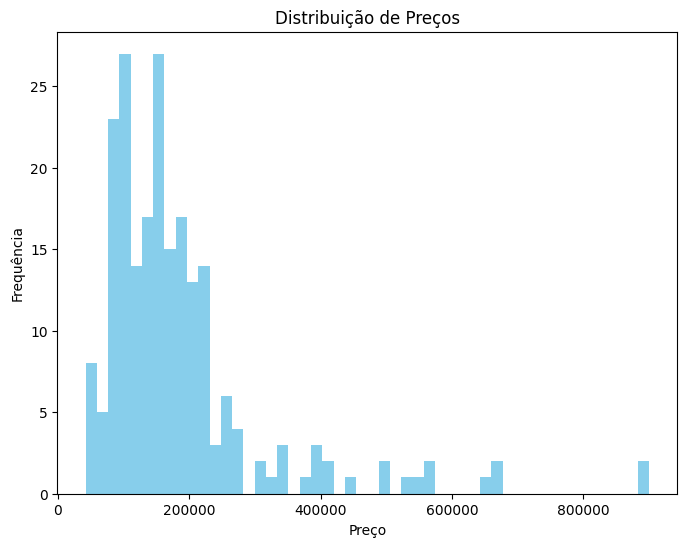

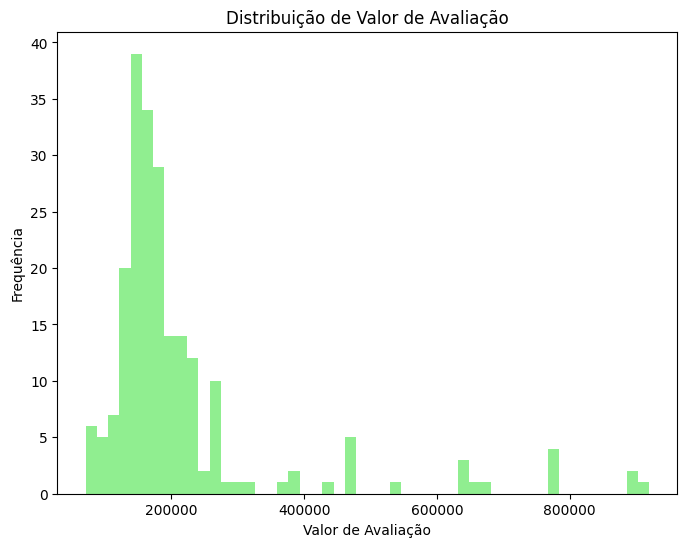

In [25]:


# # Histograma para o Preço
plt.figure(figsize=(8, 6))
df['Preço'].plot(kind='hist', bins=50, color='skyblue')
plt.title('Distribuição de Preços')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

# Histograma para o Valor de Avaliação
plt.figure(figsize=(8, 6))
df['Valor de avaliação'].plot(kind='hist', bins=50, color='lightgreen')
plt.title('Distribuição de Valor de Avaliação')
plt.xlabel('Valor de Avaliação')
plt.ylabel('Frequência')
plt.show()


### Scatter Plot

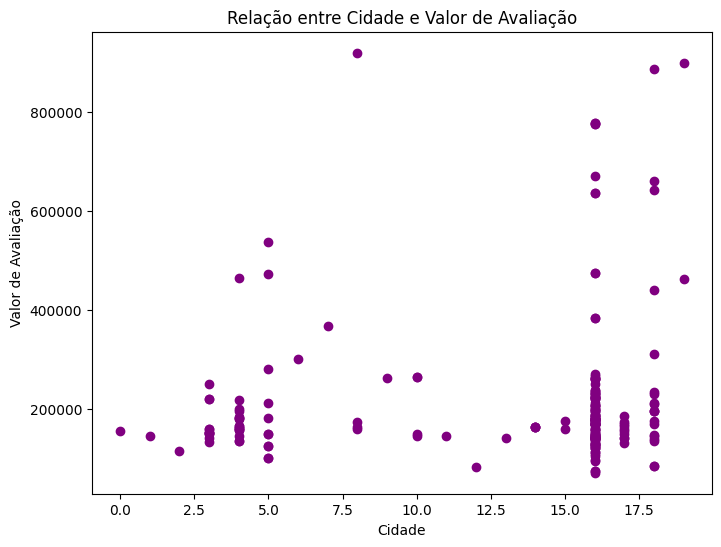

In [26]:
#Scatter Plot
# Scatter plot entre Cidade e Valor de Avaliação
plt.figure(figsize=(8, 6))
plt.scatter(df['Cidade'], df['Valor de avaliação'], color='purple')
plt.title('Relação entre Cidade e Valor de Avaliação')
plt.xlabel('Cidade')
plt.ylabel('Valor de Avaliação')
plt.show()

### Heatmap de Correlação

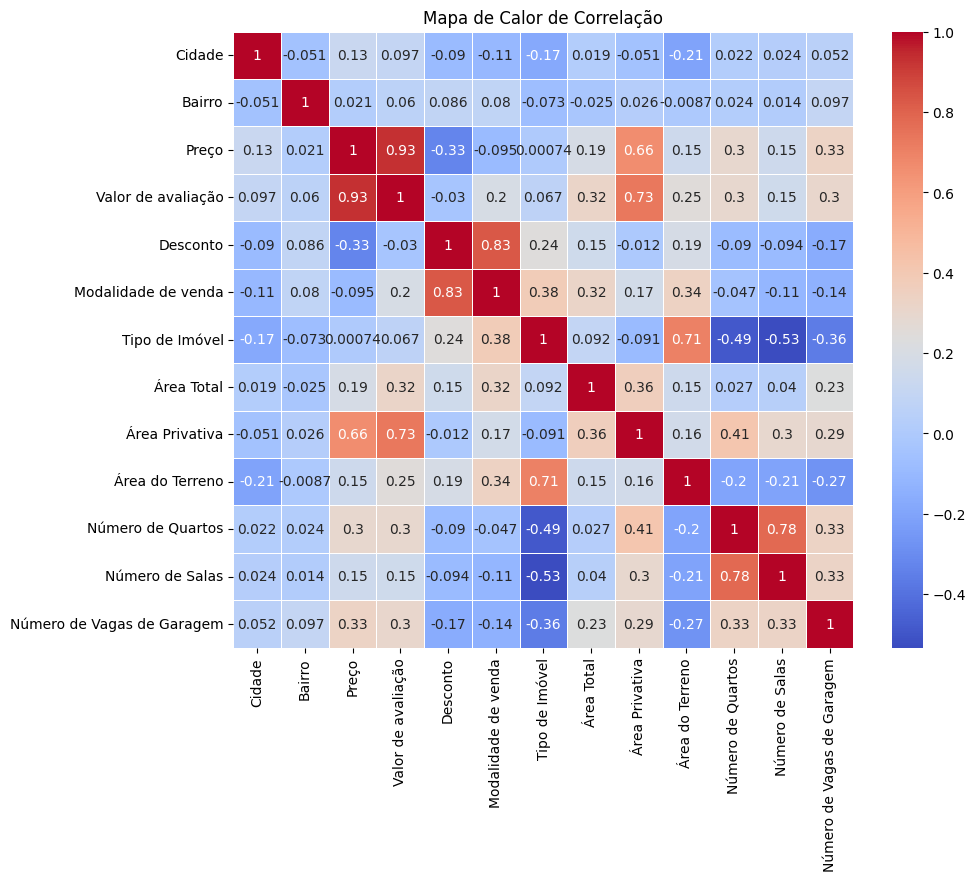

In [27]:
# Mapa de calor de correlação
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlação')
plt.show()


## 3.2 Correlação

Avalie a correlação entre as variáveis independentes e a variável dependente "Valor de avaliação" para identificar quais features podem ser mais relevantes para o modelo.

In [29]:
# Correlação entre Cidade e Valor de Avaliação
correlacao_cidade_valor = df['Cidade'].corr(df['Valor de avaliação'])
print(f"Correlação entre Cidade e Valor de Avaliação: {correlacao_cidade_valor}")

# Correlação entre Área Privativa e Valor de Avaliação
correlacao_area_privativa_valor = df['Área Privativa'].corr(df['Valor de avaliação'])
print(f"Correlação entre Área Privativa e Valor de Avaliação: {correlacao_area_privativa_valor}")

# Correlação entre Área do Terreno e Valor de Avaliação
correlacao_area_terreno_valor = df['Área do Terreno'].corr(df['Valor de avaliação'])
print(f"Correlação entre Área do Terreno e Valor de Avaliação: {correlacao_area_terreno_valor}")

# Correlação entre Tipo de Imóvel e Valor de Avaliação
correlacao_tipo_imovel_valor = df['Tipo de Imóvel'].corr(df['Valor de avaliação'])
print(f"Correlação entre Tipo de Imóvel e Valor de Avaliação: {correlacao_tipo_imovel_valor}")

# Correlação entre Número de Quartos e Valor de Avaliação
correlacao_num_quartos_valor = df['Número de Quartos'].corr(df['Valor de avaliação'])
print(f"Correlação entre Número de Quartos e Valor de Avaliação: {correlacao_num_quartos_valor}")

Correlação entre Cidade e Valor de Avaliação: 0.09667827596273404
Correlação entre Área Privativa e Valor de Avaliação: 0.7311104647577815
Correlação entre Área do Terreno e Valor de Avaliação: 0.24847912647986786
Correlação entre Tipo de Imóvel e Valor de Avaliação: 0.0671033862275154
Correlação entre Número de Quartos e Valor de Avaliação: 0.2950262740189995


# 4 Divisão dos Dados

In [30]:
# Definindo X e y
X = df.drop('Valor de avaliação', axis=1)  # Variáveis independentes
y = df['Valor de avaliação']  # Variável dependente

# Dividindo os dados em conjuntos de treinamento e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 5 Construção do Modelo

In [31]:
# Instanciar o modelo
modelo = LinearRegression()

# Treinar o modelo
modelo.fit(X_train, y_train)

# Visualizar os coeficientes do modelo
print("Coeficientes do modelo:")
print(modelo.coef_)

print("\nIntercepto do modelo:")
print(modelo.intercept_)


Coeficientes do modelo:
[-3.82383889e+01  5.45788231e+01  1.15377985e+00  1.59446142e+03
  2.78027558e+04 -1.52076652e+04  3.94011428e+02  1.07137545e+02
  6.73078104e+01 -5.32671205e+03  4.89029322e+03 -2.02063432e+03]

Intercepto do modelo:
-36652.72391622572


# 6 Avaliação do Modelo

In [32]:
# Fazer previsões no conjunto de teste
y_pred = modelo.predict(X_test)

# Calcular MSE e R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erro Quadrático Médio (MSE):", mse)
print("Coeficiente de Determinação (R²):", r2)


Erro Quadrático Médio (MSE): 768551233.8198005
Coeficiente de Determinação (R²): 0.9656463149920793
